## Demo of audio classifier visualizer.

Visualizes predictions made by an audio classifier model on an audio sample.

## Install dependencies and a classifier

In [1]:
%%capture
%pip install --quiet git+https://github.com/ramayer/elephant-rumble-inference@v0.9.0-rc1

In [2]:
import audio_classifier_visualizer as acv
import elephant_rumble_inference as eri
import IPython.display as ipd
import librosa
import torch
from PIL import Image
from audio_classifier_visualizer import RavenLabel
DEVICE = 'cpu'

## Grab 5 minutes of an interesting audio file.

In [10]:
audio_path = '/tmp/test.wav'
y,sr = librosa.load(audio_path, sr=None,duration=60*5)
if listen_to_audio := False:
    # makes the saved notebook large
    ipd.Audio(y,rate=sr)


## Run an audio classifier on that audio clilp

In [4]:
aves_hubert_model          = eri.AvesTorchaudioWrapper().to(DEVICE)
elephant_rumble_classifier = eri.ElephantRumbleClassifier().to(DEVICE)
audio_file_processor       = eri.AudioFileProcessor(aves_hubert_model,elephant_rumble_classifier,device=DEVICE)
elephant_rumble_classifier.load_pretrained_weights('best.pth')
scores = audio_file_processor.classify_wave_file_for_rumbles(audio_path, limit_audio_hours=1)
probabilities = torch.nn.functional.softmax(4*scores/torch.max(torch.abs(scores)), dim=1)
feature_rate = audio_file_processor.rumble_sr / audio_file_processor.audio_samples_per_embedding
torch.save(probabilities,'/tmp/elephant_probabilities.bin')
print(probabilities[0:5])

/home/ron/.local/share/hatch/env/virtual/audio-classifier-visualizer/-kFJ_BLn/audio-classifier-visualizer/lib/python3.12/site-packages/elephant_rumble_inference/aves_torchaudio_wrapper.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue 

Classifying hour 0 of /tmp/test.wav torch.Size([0, 1]), torch.Size([1800000, 1]), torch.Size([5120, 1])
tensor([[0.9137, 0.0863],
        [0.7745, 0.2255],
        [0.4351, 0.5649],
        [0.5221, 0.4779],
        [0.5460, 0.4540]])


## Generate a visualization


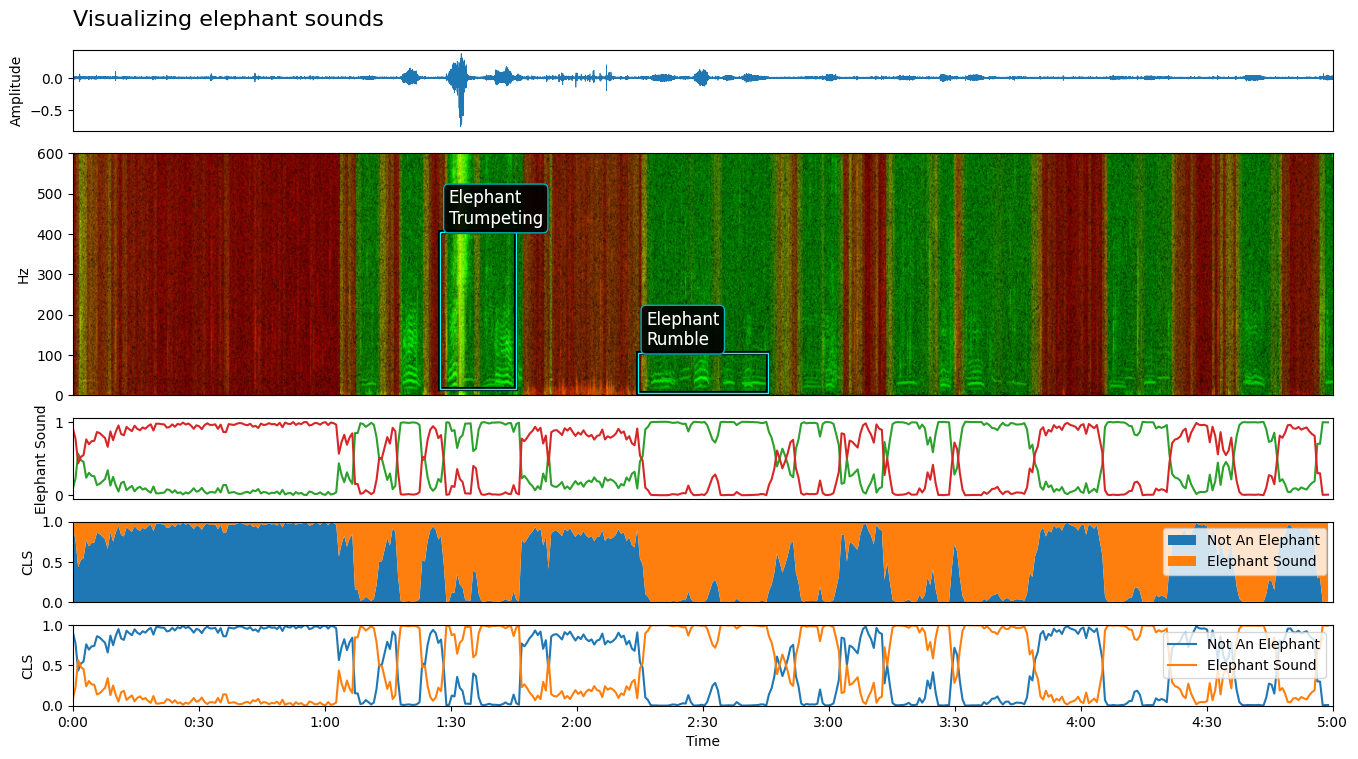

In [5]:

audio_file_processor = acv.AudioFileProcessor()

demo_labels = [
    RavenLabel(bt=88, et=105, lf=20, hf=400, notes="Elephant\nTrumpeting", score=0.95),
    RavenLabel(bt=2*60+15, et=2*60+45, lf=10, hf=100,notes="Elephant\nRumble", score=0.85)
]

audio_file_visualizer = acv.AudioFileVisualizer(audio_path, 
                                                start_time=0, end_time=60*5,
                                                feature_rate=feature_rate,
                                                class_probabilities=probabilities[0:468],
                                                n_fft=512,
                                                sr=1200,
                                                label_boxes=demo_labels,
                                                class_labels=["Not An Elephant", "Elephant Sound"],)

title = "Visualizing elephant sounds"
audio_file_visualizer.visualize_audio_file_fragment(title, width=14, height=8).show()
